# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 15 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Конопаткин".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [2]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

%load_ext pycodestyle_magic

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

<b>Задача 1. Сходимость kmeans.</b>

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

kmeans минимизирует среднее внутрикластерное расстояние, или среднее расстояние до центроид:

$$R = \frac{1}{N}\sum_{i=1}^{N}||\mathbf{x_i} - \mathbf{c_{x_i}}|| = \frac{1}{N}\sum_{i=1}^{N}\sum_{\mathbf{x} \in C_i} ||\mathbf{x} - \mathbf{c_i}||$$

Очевидно, что $R > 0$

На каждом Е-шаге объект присваивается к кластеру, соответствующему ближайшему центроиду, что очевидно уменьшает левую сумму. <br>
На каждом M-шаге идёт пересчёт центроид, что минимизирует каждую внутреннюю сумму в правой сумме, т.к.

$$\frac{d}{d\mathbf{x}}\left( \frac{1}{N}\sum_{i=1}^{N}\sum_{\mathbf{x} \in C_i} ||\mathbf{x} - \mathbf{c_i}|| \right) = \frac{d}{d\mathbf{x}}\left( \frac{1}{N}\sum_{i=1}^{N}\sum_{\mathbf{x} \in C_i} (\mathbf{x} - \mathbf{c_i}) (\mathbf{x} - \mathbf{c_i}) \right) = \frac{2}{N}\sum_{i=1}^{N}\sum_{\mathbf{x} \in C_i} (\mathbf{x} - \mathbf{c_i}) = 0$$

$$\mathbf{c_i} = \frac{1}{N_{C_i}}\sum_{\mathbf{x} \in C_i} \mathbf{x}$$

Получаем монотонную ограниченную последовательность $R_k$, которая, очевидно, сходится. <br>
Поскольку алгоритм сходится, когда метки классов у всех объектов перестают меняться, одна итерация алгоритма однозначно переводит одно распределение меток в другое, а распределений из $k$ меток на $N$ объектов ровно $k^N$, число итераций до сходимости не может превышать $k^N$

<b>Задача 2. Сходимость EM.</b>

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

Если сопоставить kmeans и EM, получим, что $\gamma(z_{nk}) = 1$ если объект $n$ принадлежит кластеру $k$, иначе $\gamma(z_{nk}) = 0$,  <br> $\mu_k$ - центроид класса $k$,  $N_k$ - число объектов в классе $k$,  $\Sigma_k$ - среднее расстояние до центроида класса $k$.

Получается, что если правдоподобие увеличивается с уменьшением ковариации $\mathbf\Sigma$, алгоритм будет сходиться?

<b>Задача 3. Формулы Ланса-Вильямса.</b>

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

Пусть $d_{\min}(U, S) < d_{\min}(V, S)$, тогда

$d_{\min}(U \cup V, S) = d_{\min}(U, S) = \frac{1}{2}(d_{\min}(U, S) + d_{\min}(V, S)) + \frac{1}{2}(d_{\min}(U, S) - d_{\min}(V, S)) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) | $

Иначе, если $d_{\min}(U, S) \ge d_{\min}(V, S)$, то

$d_{\min}(U \cup V, S) = d_{\min}(V, S) = \frac{1}{2}(d_{\min}(U, S) + d_{\min}(V, S)) - \frac{1}{2}(d_{\min}(U, S) - d_{\min}(V, S)) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) | $

<br>

Аналогично, пусть $d_{\max}(U, S) > d_{\max}(V, S)$, тогда

$d_{\max}(U \cup V, S) = d_{\max}(U, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) | $

Иначе, если $d_{\max}(U, S) \le d_{\max}(V, S)$, то

$d_{\max}(U \cup V, S) = d_{\max}(V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) | $

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [3]:
#%%pycodestyle

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import pairwise_distances


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self, k=3, linkage='single', **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """

        self.k = k
        if linkage == 'single':
            self.dist_func = self.single_linkage
        elif linkage == 'complete':
            self.dist_func = self.complete_linkage
        elif linkage == 'average':
            self.dist_func = self.average_linkage
        else:
            raise ValueError("Invalid linkage \"%s\"".format(linkage))

        return

    def single_linkage(self, U, V, S):
        d_US = self.dists[U][S]
        d_VS = self.dists[V][S]
        return 0.5 * d_US + 0.5 * d_VS - 0.5 * abs(d_US - d_VS)

    def complete_linkage(self, U, V, S):
        d_US = self.dists[U][S]
        d_VS = self.dists[V][S]
        return 0.5 * d_US + 0.5 * d_VS + 0.5 * abs(d_US - d_VS)

    def average_linkage(self, U, V, S):
        a_U = self.linkage[self.cur_clust[U]][2]
        a_V = self.linkage[self.cur_clust[V]][2]
        a_UV = a_U + a_V
        return a_U / a_UV * self.dists[U][S] + a_V / a_UV * self.dists[V][S]

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.dists = pairwise_distances(x, x)
        self.dists[range(x.shape[0]), range(x.shape[0])] = np.inf

        # первые 2 числа - номера склеиваемых кластеров, или -1 и номер отдельной вершины
        # третье - размер кластера, четвёртое - расстояние между склеиваемыми
        self.linkage = [[-1, i, 1, 0] for i in range(x.shape[0])]
        self.cur_clust = np.arange(x.shape[0])

        for i in range(x.shape[0], x.shape[0] * 2 - 1):
            u, v = np.unravel_index(np.argmin(self.dists, axis=None), self.dists.shape)
            dist = self.dists[u, v]
            U, V = self.cur_clust[u], self.cur_clust[v]

            mask = np.ones(self.cur_clust.shape, dtype=bool)
            mask[[u, v]] = False

            new_dists = np.apply_along_axis(lambda S: self.dist_func(u, v, S), 0, mask)

            self.dists = self.dists[mask]
            self.dists = self.dists[:, mask]
            self.dists = np.append(self.dists, new_dists.reshape(-1, 1), axis=1)
            new_dists = np.append(new_dists, [np.inf])
            self.dists = np.append(self.dists, new_dists.reshape(1, -1), axis=0)

            self.linkage.append([U, V, dist, self.linkage[U][2] + self.linkage[V][2]])
            self.cur_clust = self.cur_clust[mask]
            self.cur_clust = np.append(self.cur_clust, [i])

        return self

    def predict(self, x, k=None):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        if k is None:
            k = self.k

        labels = [None for i in range(x.shape[0])]

        cur_heads = set(range(len(self.linkage) - k + 1))
        cur = len(self.linkage) - k

        cur_label = 0
        while cur > 0:
            if cur in cur_heads:
                cur_elems = {cur}
                while len(cur_elems) > 0:
                    elem = cur_elems.pop()
                    cur_heads.remove(elem)
                    U, V = self.linkage[elem][:2]
                    if U == -1:
                        labels[V] = cur_label
                    else:
                        cur_elems |= {U, V}
                cur_label += 1
            cur -= 1

        return labels

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

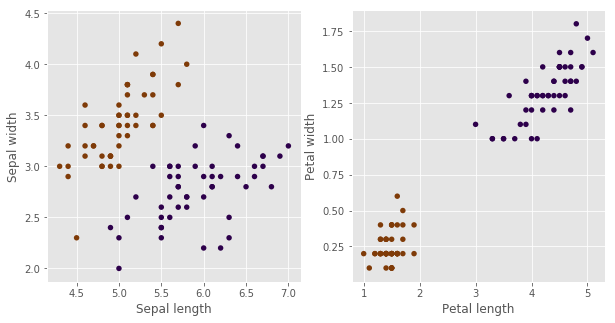

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [5]:
%time pred_iris = Clustering(k=2, linkage='single').fit_predict(x_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Wall time: 23 ms
Adjusted Rand index for iris is: 1.00


In [6]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
%time aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

Wall time: 12 ms
GMM score 1.0. GMM time 0.009000539779663086. AGGL score 1.0. AGGL time 0.013000726699829102


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [7]:
# Место для Вашего кластерного анализа

In [8]:
raw_data = pd.read_csv("data/WDIData.csv").drop(columns=["Unnamed: 62"])

In [9]:
raw_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.243897,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.432827,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.402277,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN


In [10]:
print(len(set(raw_data["Indicator Name"])) == len(set(raw_data["Indicator Code"])))
print(len(set(raw_data["Country Name"])) == len(set(raw_data["Country Code"])))

True
True


In [12]:
'''%%time
years_data = {}
size = len(raw_data.columns[4:])
for i, year in zip(range(size), raw_data.columns[4:]):
    print("\r {} ({} from {})".format(year, i + 1, size), end = '')
    cur_data = raw_data[["Country Name", "Indicator Name", year]]
    cur_year = {}
    for country in pd.unique(cur_data["Country Name"]):
        cur_country = cur_data[cur_data["Country Name"] == country]
        cur_year[country] = cur_country.sort_values("Indicator Name")[year].values
    years_data[year] = pd.DataFrame(cur_year, index=pd.unique(cur_data["Indicator Name"]))
print()

#  2017 (58 from 58)
#  Wall time: 8min 11s'''
''

''

In [13]:
'''for year in years_data:
    years_data[year].to_csv("data/Data_parsed_{}.csv".format(year))'''
''

''

In [14]:
%%time
years_data = {}
size = len(raw_data.columns[4:])
for i, year in zip(range(size), raw_data.columns[4:]):
    print("\r {} ({} from {})".format(year, i + 1, size), end='')
    years_data[year] = pd.read_csv("data/Data_parsed_{}.csv".format(year))
    years_data[year] = years_data[year].rename(index=years_data[year]["Unnamed: 0"]).drop(columns=["Unnamed: 0"])
print()

# Wall time: 7.77 s

 2017 (58 from 58)
Wall time: 7.77 s


In [15]:
years_data["2017"].T.head()

,"2005 PPP conversion factor, GDP (LCU per international $)","2005 PPP conversion factor, private consumption (LCU per international $)",Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)",...,"Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%)
Arab World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.165211,25.635403,48.328518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Caribbean small states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Central Europe and the Baltics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Early-demographic dividend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.378037
East Asia & Pacific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.693977,71.484467,75.922256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
years_data_filled = {}
for year in years_data:
    years_data_filled[year] = years_data[year].fillna(0.0).T

In [17]:
years_data_filled["2017"].head()

,"2005 PPP conversion factor, GDP (LCU per international $)","2005 PPP conversion factor, private consumption (LCU per international $)",Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)",...,"Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%)
Arab World,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.165211,25.635403,48.328518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Caribbean small states,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Central Europe and the Baltics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Early-demographic dividend,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.378037
East Asia & Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.693977,71.484467,75.922256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [18]:
from scipy.cluster.hierarchy import dendrogram

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

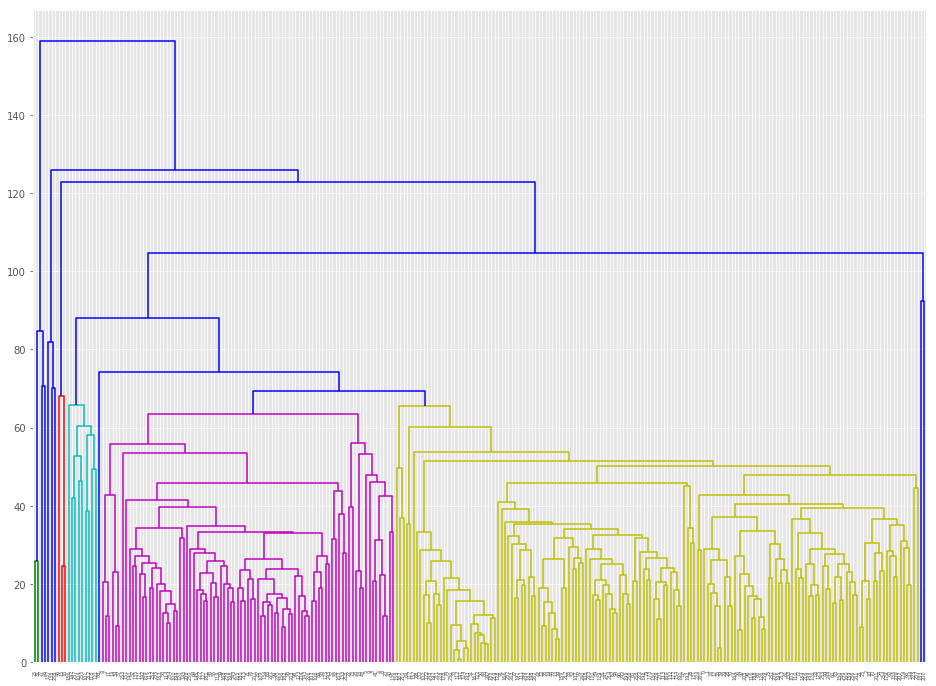

In [19]:
scaler = StandardScaler()
clf = Clustering(k=13, linkage='complete')
labels = clf.fit_predict(scaler.fit_transform(years_data_filled["2017"].values))

fig = plt.figure(figsize=(16,12))
dend = dendrogram(clf.linkage[years_data_filled["2017"].shape[0]:], color_threshold=68)

In [20]:
%%time
labels_data = {}
clusters_data = {}
size = len(years_data_filled)
#k = 13
k = 25
for i, year in zip(range(size), years_data_filled):
    print("\r {} ({} from {})".format(year, i + 1, size), end='')
    scaler = StandardScaler()
    clf = Clustering(k=k, linkage='complete')
    labels = clf.fit_predict(scaler.fit_transform(years_data_filled[year].values))
    
    clust_sizes = list(sorted([(sum([label == i for label in labels]), i) for i in range(k)], reverse=True))
    label_map = {clust_sizes[i][1] : i for i in range(k)}
    
    clusters_data[year] = [clust_sizes[i][0] for i in range(k)]
    labels_data[year] = [label_map[label] for label in labels]
print()
labels_data = pd.DataFrame(labels_data, index=years_data_filled["2017"].index)
clusters_data = pd.DataFrame(clusters_data)

 2017 (58 from 58)
Wall time: 8.17 s


In [21]:
labels_data.T

,Arab World,Caribbean small states,Central Europe and the Baltics,Early-demographic dividend,East Asia & Pacific,East Asia & Pacific (excluding high income),East Asia & Pacific (IDA & IBRD countries),Euro area,Europe & Central Asia,Europe & Central Asia (excluding high income),...,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,"Yemen, Rep.",Zambia,Zimbabwe
1960,0,0,1,9,3,3,3,7,3,1,...,1,0,0,0,0,0,2,0,0,0
1961,0,0,0,7,3,3,3,6,3,0,...,0,0,0,0,0,0,1,0,0,0
1962,0,0,0,9,3,3,3,2,2,0,...,0,0,0,0,0,0,1,0,0,0
1963,0,0,4,10,4,4,4,9,4,4,...,1,0,0,1,0,0,2,0,0,0
1964,0,0,0,11,4,4,4,9,9,0,...,5,0,0,0,0,0,1,0,2,2
1965,0,0,0,9,0,0,0,8,8,0,...,24,0,0,0,0,0,2,0,0,0
1966,0,0,0,12,3,3,3,8,8,0,...,0,0,0,0,0,0,1,0,0,0
1967,0,0,0,9,3,3,3,6,6,0,...,24,0,0,0,0,0,1,0,0,0
1968,0,0,0,7,0,0,0,5,5,0,...,0,0,0,0,0,0,1,0,0,0
1969,0,0,0,8,3,3,3,6,6,0,...,0,0,0,0,0,0,1,0,0,0


In [22]:
clusters_data.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1960,162,40,26,6,4,3,3,2,2,1,...,1,1,1,1,1,1,1,1,1,1
1961,188,26,14,9,4,3,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1962,181,26,14,9,7,4,3,2,2,1,...,1,1,1,1,1,1,1,1,1,1
1963,123,53,26,16,15,5,3,3,3,2,...,1,1,1,1,1,1,1,1,1,1
1964,159,26,20,19,6,5,4,3,3,3,...,1,1,1,1,1,1,1,1,1,1
1965,146,34,26,21,7,4,4,3,3,1,...,1,1,1,1,1,1,1,1,1,1
1966,174,26,16,12,4,4,3,3,3,2,...,1,1,1,1,1,1,1,1,1,1
1967,181,26,17,9,4,3,3,3,2,1,...,1,1,1,1,1,1,1,1,1,1
1968,189,26,19,4,3,3,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1969,182,26,19,8,4,3,3,2,1,1,...,1,1,1,1,1,1,1,1,1,1


In [23]:
clusters = [[] for i in range(k)]
for label, elem in zip(labels_data["2004"].values, labels_data["2004"].index):
    clusters[label].append(elem)
#print(*map(len, clusters.values()), sep='\n')
print(*clusters, sep='\n\n')

['Arab World', 'Caribbean small states', 'Europe & Central Asia (IDA & IBRD countries)', 'Fragile and conflict affected situations', 'IDA blend', 'Latin America & Caribbean', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Middle East & North Africa', 'Middle East & North Africa (excluding high income)', 'Middle East & North Africa (IDA & IBRD countries)', 'Not classified', 'Other small states', 'Pacific island small states', 'Small states', 'Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Barbados', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'British Virgin Islands', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cayman Islands', 'Central African Republic', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Cuba', 'Curacao', 'Djibouti', 'D

In [24]:
labels_data.T["Russian Federation"]

1960     1
1961     0
1962     0
1963     0
1964     0
1965     0
1966     0
1967     0
1968     0
1969     0
1970     0
1971     0
1972     0
1973     0
1974     0
1975     0
1976     0
1977     0
1978     0
1979     0
1980     0
1981     0
1982     0
1983     0
1984     0
1985     0
1986     0
1987     0
1988     0
1989     0
1990     0
1991     0
1992     4
1993     1
1994     1
1995     0
1996     1
1997     2
1998     1
1999     1
2000     3
2001     0
2002    11
2003     6
2004     5
2005    11
2006    13
2007     9
2008    10
2009    11
2010    21
2011     7
2012    22
2013     1
2014    21
2015    22
2016    19
2017     1
Name: Russian Federation, dtype: int64

Совсем непонятно, что происходит. Кластеризация через single linkage и average linkage даёт ещё больше отдельно стоящих стран.

Самая большая группа - возможно большинство относительно малоразвитых стран (в основном Африка) или страны, по которым мало данных (Россия до 1990-ых попадает сюда); <br> 
вторая группа - в основном Европа; <br>
часто в отдельные группы выделяются не страны, а категории стран (в стиле 'Heavily indebted poor countries (HIPC)', 'Least developed countries: UN classification', 'Low income', и т.д.) <br>

группы после 9-10 в основном отдельные страны, например, США всегда оказывается в отдельной группе. <br>
Россия почему-то болтается между Европой и отдельной группой...

In [ ]:
# Не переживайте, мне тоже было тяжело разобраться с данными

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваш ответ здесь***
* * Если стоит задача поиска закономерностей в данных, имеет смысл сначала попытаться разбить данные на кластеры.
* * В информационном поиске бывает полезно кластеризовать выдачу, чтобы в топе не было очень похожих документов с максимальной релевантностью, а был адекватный разброс по возможным смыслам запроса.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваш ответ здесь***
* * <i>kmeans</i> имеет самую простую реализацию, но находит только кластеры одинаковой примерно сферической формы, для кластеров произвольной формы с большой вероятностью поделит данные криво. Также нужно заранее задавать число кластеров.
* * <i>агломеративная кластеризация</i> позволяет один раз построить полное разбиение, нарисовать дендрограмму и потом уже выбрать адекватное число кластеров, однако имеет тенденцию к выделению очень мелких кластеров (~шум)
* * <i>dbscan</i> не требует задавать заранее число кластеров, однако требует задать $\epsilon$ и $M$, что может быть даже более сложно сделать для получения адекватных результатов, но зато может выделять кластеры совсем произвольной формы, если только плотность точек везде одинаковая
* * * Есть ещё замечательный алгоритм <i>OPTICS</i>, придуманный ещё до 2000 года, который почему-то только сейчас хотят включить в sklearn. Он позволяет глазами увидеть кластерную структуру данных и вложенность кластеров,не очень долго работает и не очень сложный, непонятно, почему при всём этом он так мало распространён.

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваш ответ здесь***

* * С матстатом у меня довольно плохо... Говорят, что оценка максимального правдоподобия может требовать очень большого количества данных для того, чтобы дать адекватный результат...

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

***Ваш ответ здесь***

* * Конечно страдают, поскольку суть проклятья размерности в том, что при большой размерности нужно собрать очень много данных для того, чтобы они не казались разреженными и можно было выделить кластеры. Нужно понижать размерность при помощи специальных методов (как в 9 лекции)

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваш ответ здесь***

* * Можно попытаться кластеризовать документы, а затем вручную посмотреть на несколько документов из каждого класса и пометить весь класс предполагаемой меткой (говорят, что человек учится различать предметы примерно так же).
* * В качестве признаков можно использовать мешок слов / n-граммы / tf-idf / волшебные векторизации (типа word2vec)



* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваш ответ здесь***

* * Можно поступить как в предыдущем пункте, и присвоить кластерам самую частую метку из размеченных объектов в кластере.
* * В итеративных алгоритмах типа kmeans и EM можно попытаться добавить к минимизируемому функционалу штраф в стиле RandIndex (пропорциональный числу пар из размеченных объектов с разными метками внутри одного кластера)


Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***